In [1]:
import numpy as np
import scipy.linalg as linalg
import matplotlib.pyplot as plt
from scipy.special import p_roots

In [2]:
def Get_Input(h):
    L=1 #邊長
    L_x=L
    L_y=L

    N_ex=int(L_x/h) #元素數量
    N_ey=int(L_y/h)
    # print(N_ex)
    N_x=N_ex+1 #節點數
    N_y=N_ey+1
    L_ex=L_x/N_ex #每個元素長度
    # print(L_ex)
    L_ey=L_y/N_ey
    N_e=N_ex*N_ey #總元素數量
    N_node=N_x*N_y #總結點數
    # print(N_node)
    Dof=1 #自由度 因為是熱傳問題，所以dof=1

    Parameter=[N_ex,N_ey,N_x,N_y,L_ex,L_ey,N_e,N_node,Dof] #各項參數
    Constant=[L,L_x,L_y] #常數

    N_xy=np.zeros([N_node,2])

    for i in range(N_node):
        ii=(i+1) % N_x #對結點數的餘數
        if(ii==0):
            ii=N_x
        j=np.ceil((i+1)/N_x)
        N_xy[i,0:2]=[L_ex*(ii-1),L_ey*(j-1)]

    #construct element conduction and EFT
    EFT=np.zeros([N_e,4],dtype=int) #每個元素4個節點
    k=0
    for i in range(1,N_ex+1):
        for j in range(1,N_ey+1):
            EFT[k,0:4]=[i+(j-1)*N_x,i+1+(j-1)*N_x,i+N_x+(j-1)*N_x,i+N_x+1+(j-1)*N_x]
            k+=1

    return Constant,Parameter,N_xy,EFT

In [3]:
Constant,Parameter,N_xy,EFT=Get_Input(1/2)
# print(Constant[:3])
print(Parameter)
print(EFT)
# # print(EFT[0, [0, 1, 3, 2]])
# numNode = Parameter[7]
# # print(EFT[0,0])
# print(N_xy)
# print(EFT)
# print(N_xy[EFT[0,0],:2])

#K_global[EFT[idxEle, [0, 1, 3, 2]], EFT[idxEle, [0, 1, 3, 2]]] += K_local
# K_global=np.zeros([numNode,numNode])
# K_local=np.array([[1,2,3,4],[3,4,5,6],[5,6,7,8],[7,8,9,10]])
# A=EFT[3, [0, 1, 3, 2]]
# # print(A)
# for i in range(len(A)):
#     for j in range(len(A)):
#         K_global[A[i]-1,A[j]-1]+=K_local[i,j]
# print(K_global)
# K_global[[1 2 5 4],[1 2 5 4]]+=K_local

[2, 2, 3, 3, 0.5, 0.5, 4, 9, 1]
[[1 2 4 5]
 [4 5 7 8]
 [2 3 5 6]
 [5 6 8 9]]


In [4]:
def GaussQuad(n,a,b):
    # Compute the points and weights for the Gaussian quadrature rule
    x, w = p_roots(n) #n代表切幾塊
    #print(x) #點的位置
    #print(w) #權重
    # Scale the points and weights to the interval [a, b]
    x_scaled = (b - a) / 2 * x + (a + b) / 2 #邊界[-1,1]所以x_scaled=x
    w_scaled = (b - a) / 2 * w #邊界[-1,1]所以w_scaled=w
    #print(x_scaled)
    #print(w_scaled)
    # Evaluate the function at the quadrature points and sum the results
    #integral = np.sum(w_scaled * f(x_scaled))

    return x_scaled,w_scaled

In [5]:
from scipy.integrate import quad
#測試高斯積分
# 定義要積分的函數
def f(x):
    return x ** 2

# 計算從-1到1的定積分
result, error = quad(f, -1, 1)
xx,ww=GaussQuad(4,-1,1)
# print([xx,ww])
integral = np.sum(ww * f(xx))
print(result)  # 輸出解析解積分結果
#print(error)
print(integral) #輸出高斯積分輸出結果

# x,w=GaussQuad(4,-1,1)
# print(w)

0.6666666666666666
0.6666666666666666


In [6]:
N_matrix=lambda xi,eta:np.array([
        [(1/4)*(1-xi)*(1-eta),(1/4)*(1+xi)*(1-eta),
        (1/4)*(1+xi)*(1+eta),(1/4)*(1-xi)*(1+eta)]
    ])
xi=1
eta=1
N=N_matrix(xi,eta)
print(N)

[[0. 0. 1. 0.]]


In [27]:
def Main(h):
    #Define Input
    Constant,Parameter,nodalPosition,EFT=Get_Input(h)

    #Extract variable from input
    L,L_x,L_y=Constant[:3]
    #Parameter=[N_ex,N_ey,N_x,N_y,L_ex,L_ey,N_e,N_node,Dof] #各項參數
    #Parameter=[2,2,3,3,0.5,0.5,4,9,1] if h=1/2
    numNode_x,number_Element,numNode,dof=Parameter[2],Parameter[6],Parameter[7],Parameter[8]

    K_global=np.zeros([numNode*dof,numNode*dof])
    F_global=np.zeros([numNode*dof,1])

    #Gauss Intergration

    gaussPoint_x,gaussWeight_x=GaussQuad(2,-1,1)
    gaussPoint_y=gaussPoint_x
    gaussWeight_y=gaussWeight_x

    #Define N & B in xi and eta domain
    #N_matrix=[N1,N2,N3,N4]
    N_matrix=lambda xi,eta:np.array([
        [(1/4)*(1-xi)*(1-eta),(1/4)*(1+xi)*(1-eta),
        (1/4)*(1+xi)*(1+eta),(1/4)*(1-xi)*(1+eta)]
    ])
    #B_matrix=[[N1.xi,N2.xi,N3.xi,N4.xi][N1.eta,N2.eta,N3.eta,N4.eta]]
    B_matrix=lambda xi,eta:np.array([
        [(1/4)*(eta-1),(1/4)*(1-eta),(1/4)*(eta+1),(1/4)*(-1-eta)],
        [(1/4)*(xi-1),(1/4)*(-1-xi),(1/4)*(xi+1),(1/4)*(1-xi)]
    ])

    #Run into the loop for the stiffness and source heat
    for idxEle in range(number_Element): #loop over element # if h=1/2 numEle=4 
        x1,y1=nodalPosition[EFT[idxEle,0]-1,:2]
        x2,y2=nodalPosition[EFT[idxEle,1]-1,:2]
        x3,y3=nodalPosition[EFT[idxEle,3]-1,:2]
        x4,y4=nodalPosition[EFT[idxEle,2]-1,:2]

        xI_local=np.array([x1,x2,x3,x4]) #1*4
        yI_local=np.array([y1,y2,y3,y4]) #1*4
        K_local=np.zeros([4,4])
        Fq_local=np.zeros([4,1])

        #Gauss intergration
        for idxGauss_x in range(len(gaussPoint_x)):
            for idxGauss_y in range(len(gaussPoint_y)): #n*n
                #Gauss point position xi,eta
                xi=gaussPoint_x[idxGauss_x]
                eta=gaussPoint_y[idxGauss_y]

                #Compute ShapeFunction N
                N=N_matrix(xi,eta)

                #x,y coordinate in xi and eta by isoparametric mapping
                x_xi=np.dot(xI_local,np.transpose(N)) #1*4@4*1 = 1
                y_xi=np.dot(yI_local,np.transpose(N)) #1*4@4*1 = 1

                #Gradient matrix in xi amd eta domain
                B_xi=B_matrix(xi,eta) #2*4
                A00=np.dot(xI_local,np.transpose(B_xi[0,:])) #1*4@4*1 = 1
                A01=np.dot(yI_local,np.transpose(B_xi[0,:])) #1*4@4*1 = 1
                A10=np.dot(xI_local,np.transpose(B_xi[1,:])) #1*4@4*1 = 1
                A11=np.dot(yI_local,np.transpose(B_xi[1,:])) #1*4@4*1 = 1
                A=np.array([[A00,A01],[A10,A11]]) #2*2
                B = np.linalg.solve(A, B_xi)
                # B=A@B_xi

                #matrix assembly for K and F body force
                # fq=(-100)*(2/(50*(np.pi**2)))*np.sin(np.pi*x_xi/2)*np.sin(np.pi*y_xi/2)
                fq=(-100)*(np.exp(x_xi))*(np.exp(y_xi))
                K_local+=(B.T)@np.array([[50,0],[0,50]])@B*np.linalg.det(A.T)*gaussWeight_x[idxGauss_x]*gaussWeight_y[idxGauss_y] 
                # 4*2@2*2@2*4=4*4
                Fq_local+=np.transpose(N)*fq*np.linalg.det(A.T)*gaussWeight_x[idxGauss_x]*gaussWeight_y[idxGauss_y]

        #Boundary flux
        Fh_local=np.zeros([4,1])
        if xI_local[1]==L_x and xI_local[2]==L_x: #gamma 3 x2 x3
            for idxGauss_y in range(len(gaussPoint_y)): 
                eta=gaussPoint_y[idxGauss_y]
                xi=1

                #compute Shape finction N & B
                N=N_matrix(xi,eta)
                B_xi=B_matrix(xi,eta)

                #A matrix
                A00=np.dot(xI_local,np.transpose(B_xi[0,:])) #1*4@4*1 = 1
                A01=np.dot(yI_local,np.transpose(B_xi[0,:])) #1*4@4*1 = 1
                A10=np.dot(xI_local,np.transpose(B_xi[1,:])) #1*4@4*1 = 1
                A11=np.dot(yI_local,np.transpose(B_xi[1,:])) #1*4@4*1 = 1
                A=np.array([[A00,A01],[A10,A11]]) #2*2

                As=np.sqrt(A[1,0]**2+A[1,1]**2) #surface jacobin
                y_xi=np.dot(N,yI_local)

                u_cn=0*np.exp(1)*np.exp(y_xi)

                #Assembly
                Fh_local+=N.T * u_cn *As*gaussWeight_y[idxGauss_y]

        if yI_local[2]==L_y and yI_local[3]==L_y: #gamma 4 x3 x4
            for idxGauss_x in range(len(gaussPoint_x)):
                xi=gaussPoint_x[idxGauss_x]
                eta=1

                #compute Shape finction N & B
                N=N_matrix(xi,eta)
                B_xi=B_matrix(xi,eta)

                #A matrix
                A00=np.dot(xI_local,np.transpose(B_xi[0,:])) #1*4@4*1 = 1
                A01=np.dot(yI_local,np.transpose(B_xi[0,:])) #1*4@4*1 = 1
                A10=np.dot(xI_local,np.transpose(B_xi[1,:])) #1*4@4*1 = 1
                A11=np.dot(yI_local,np.transpose(B_xi[1,:])) #1*4@4*1 = 1
                A=np.array([[A00,A01],[A10,A11]]) #2*2

                As=np.sqrt(A[0,0]**2+A[0,1]**2) #surface jacobin
                x_xi=np.dot(N,xI_local)

                u_cn=0*np.exp(1)*np.exp(x_xi)

                Fh_local+=N.T * u_cn *As*gaussWeight_x[idxGauss_x]
        
        # assembly
        # EFT_idx = np.zeros((4, 1))
        EFT_idx=EFT[idxEle,[0, 1, 3, 2]]
        for i in range(len(EFT_idx)):
            for j in range(len(EFT_idx)):
                K_global[EFT_idx[i]-1,EFT_idx[j]-1]+=K_local[i,j]
            F_global[EFT_idx[i]-1,0]+=Fq_local[i,0]+Fh_local[i,0]
        # K_global[EFT[idxEle, [0, 1, 3, 2]], EFT[idxEle, [0, 1, 3, 2]]] += K_local
        # F_global[EFT[idxEle, [0, 1, 3, 2]], 0] += Fq_local + Fh_local        

    #Apply BCs by lagrange Multiplier method
    G_global=np.zeros([4*numNode_x-4,numNode])
    k=0
    gEBC_global=np.zeros([4*numNode_x-4,1])
    for idxGauss_x in range(numNode):
        x=nodalPosition[idxGauss_x,0]
        y=nodalPosition[idxGauss_x,1]
        if x==0 or y==0:
            G_global[k,idxGauss_x]=1
            if x==0 and y!=0:
                gEBC_global[k]=np.exp(y)
            elif y==0 and x!=0:
                gEBC_global[k]=np.exp(x)
            elif y==0 and x==0:
                gEBC_global[k]=1
            k+=1
        if(x==1 and y!=0) or (y==1 and x!=0):
            G_global[k,idxGauss_x]=1
            if x==1 and y!=1:
                gEBC_global[k]=np.exp(y)*np.exp(1)
            elif y==1 and x!=1:
                gEBC_global[k]=np.exp(x)*np.exp(1)
            elif y==1 and x==1:
                gEBC_global[k]=(np.exp(1))**2
            k+=1
    
    # Solve, Check lagrangian Formulation
    qI = np.linalg.solve(np.block([[K_global, G_global.T], [G_global, np.zeros((4 * numNode_x - 4, 4 * numNode_x - 4))]]),np.block([[F_global], [gEBC_global]]))

    #Recover the global solution that deduced by BCs
    d=qI[:numNode]
    #lambda = qI[numnode:]
    
    return d

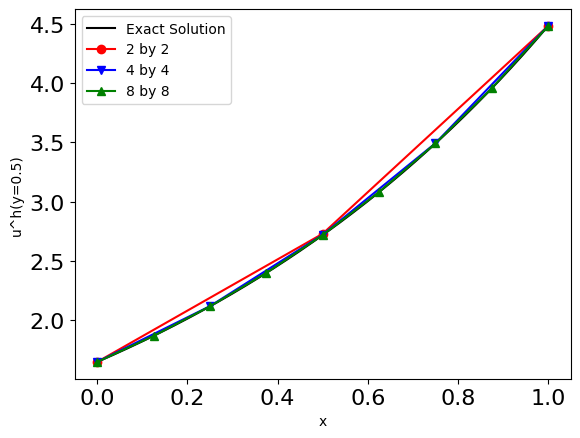

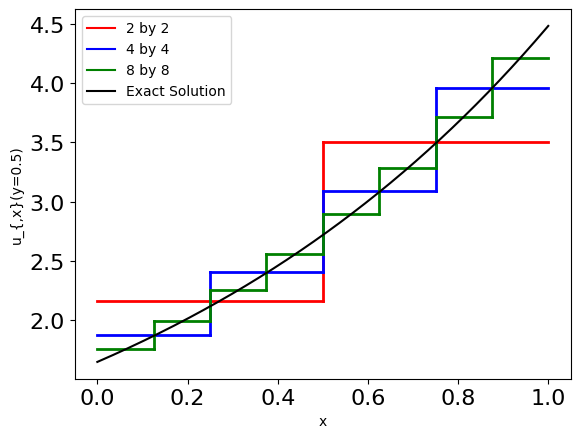

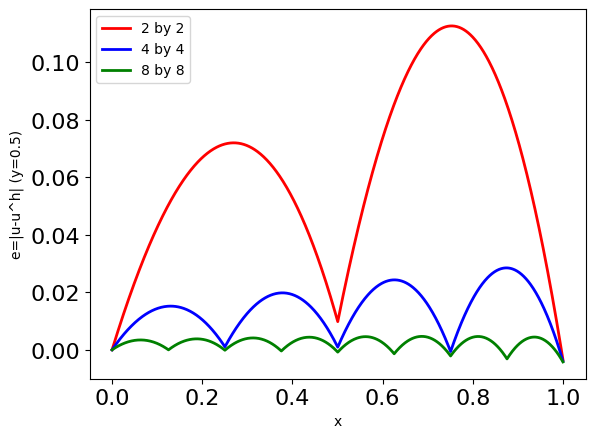

In [28]:
## question 1
hCase=[2,4,8]
for idx_xGauss in range(len(hCase)):
    L=1
    h=L/hCase[idx_xGauss]
    constant,Parameter,nodalPosition,EFT=Get_Input(h)
    node_y=Parameter[3]
    if(idx_xGauss==0):
        d_6=np.zeros([node_y,2])
    if(idx_xGauss==1):
        d_12=np.zeros([node_y,2])
    if(idx_xGauss==2):
        d_24=np.zeros([node_y,2])
# print(d_6)
# print(d_12)
# print(d_24)

for idx_xGauss in range(len(hCase)):
    L=1
    h=L/hCase[idx_xGauss]
    nodalCoefficientFEM=Main(h)
    # print(nodalCoefficientFEM[3][0])
    constant,Parameter,nodalPosition,EFT=Get_Input(h)
    # print(nodalPosition)
    
    counter_case=0
    for node in range(len(nodalCoefficientFEM)):
        if(nodalPosition[node,1]==0.5):  #y=0.5
            if(idx_xGauss==0):
                # print(node)
                # print(d_6[counter_case,:])
                # print(nodalPosition[node,0],nodalCoefficientFEM[node][0])
                d_6[counter_case,:]=[nodalPosition[node,0],nodalCoefficientFEM[node][0]]
            elif(idx_xGauss==1):
                d_12[counter_case,:]=[nodalPosition[node,0],nodalCoefficientFEM[node][0]]
            elif(idx_xGauss==2):
                d_24[counter_case,:]=[nodalPosition[node,0],nodalCoefficientFEM[node][0]]
            counter_case+=1

# print(d_6)
# print(d_12)
# print(d_24)
# x_exact=np.arange(0,0.01,1)
# y_exact=(2/(50*np.pi**2))*np.sin(np.pi*x_exact/2)*np.sin(np.pi/4)
x_exact=np.linspace(0,1,1000)
# u_exact=(2/(50*(np.pi**2)))*np.sin(np.pi*x_exact/2)*np.sin(np.pi/4)
u_exact=np.exp(x_exact)*np.exp(0.5)
plt.figure(1)
plt.plot(x_exact, u_exact, 'k-', label='Exact Solution')
plt.plot(d_6[:, 0], d_6[:, 1], 'ro-', label='2 by 2')
plt.plot(d_12[:, 0], d_12[:, 1], 'bv-', label='4 by 4')
plt.plot(d_24[:, 0], d_24[:, 1], 'g^-', label='8 by 8')

plt.legend()
plt.xlabel('x')
plt.ylabel('u^h(y=0.5)')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# question 2
plt.figure(2)

constant_2,Parameter_2,nodalPosition_2,EFT_2=Get_Input(1/hCase[0])
node_Ele2=Parameter_2[1]
dd_6=np.zeros([node_Ele2,1])
for ele in range(node_Ele2):
    dd_6[ele]=(d_6[ele+1,1]-d_6[ele,1])/(d_6[ele+1,0]-d_6[ele,0])
for ele in range(node_Ele2):
    plt.plot([d_6[ele,0],d_6[ele+1,0]],[dd_6[ele],dd_6[ele]],'r-',lw=2)
    if(ele+1<node_Ele2):
        plt.plot([d_6[ele+1,0],d_6[ele+1,0]],[dd_6[ele],dd_6[ele+1]],'r-',lw=2)

constant_4,Parameter_4,nodalPosition_4,EFT_4=Get_Input(1/hCase[1])
node_Ele4=Parameter_4[1]
dd_12=np.zeros([node_Ele4,1])
for ele in range(node_Ele4):
    dd_12[ele]=(d_12[ele+1,1]-d_12[ele,1])/(d_12[ele+1,0]-d_12[ele,0])
for ele in range(node_Ele4):
    plt.plot([d_12[ele,0],d_12[ele+1,0]],[dd_12[ele],dd_12[ele]],'b-',lw=2)
    if(ele+1<node_Ele4):
        plt.plot([d_12[ele+1,0],d_12[ele+1,0]],[dd_12[ele],dd_12[ele+1]],'b-',lw=2)

constant_8,Parameter_8,nodalPosition_8,EFT_8=Get_Input(1/hCase[2])
node_Ele8=Parameter_8[1]
dd_24=np.zeros([node_Ele8,1])
for ele in range(node_Ele8):
    dd_24[ele]=(d_24[ele+1,1]-d_24[ele,1])/(d_24[ele+1,0]-d_24[ele,0])
for ele in range(node_Ele8):
    plt.plot([d_24[ele,0],d_24[ele+1,0]],[dd_24[ele],dd_24[ele]],'g-',lw=2)
    if(ele+1<node_Ele8):
        plt.plot([d_24[ele+1,0],d_24[ele+1,0]],[dd_24[ele],dd_24[ele+1]],'g-',lw=2)

x_exact=np.linspace(0,1,1000)
plt.plot(d_6[0,0],dd_6[0], 'r-', label='2 by 2')
plt.plot(d_12[0,0], dd_12[0], 'b-', label='4 by 4')
plt.plot(d_24[0,0], dd_24[0], 'g-', label='8 by 8')
plt.plot(x_exact, np.exp(x_exact)*np.exp(0.5), 'k-',label='Exact Solution')

plt.legend()
plt.xlabel('x')
plt.ylabel('u_{,x}(y=0.5)')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# question 3
plt.figure(3)
x_exact=np.linspace(0,1,1000)
u_exact=np.exp(x_exact)*np.exp(0.5)
# print(node_Ele2)
d_6_error=np.zeros([1000])
Ele2_error=int(1000/node_Ele2)
for ele in range(1000):
    for i in range(node_Ele2):
        if(ele<Ele2_error*(i+1)):
            d_6_error[ele]=d_6[i,1]+((d_6[i+1,1]-d_6[i,1])/Ele2_error)*(ele-Ele2_error*i)
            d_6_error[ele]=d_6_error[ele]-u_exact[ele]
            break
# print(d_6_error)
# print(d_6[1,1])
# print((u_exact[500]+u_exact[499])/2)

d_12_error=np.zeros([1000])
Ele4_error=int(1000/node_Ele4)
for ele in range(1000):
    for i in range(node_Ele4):
        if(ele<Ele4_error*(i+1)):
            d_12_error[ele]=d_12[i,1]+((d_12[i+1,1]-d_12[i,1])/Ele4_error)*(ele-Ele4_error*i)
            d_12_error[ele]=d_12_error[ele]-u_exact[ele]
            break

d_24_error=np.zeros([1000])
Ele8_error=int(1000/node_Ele8)
# print(node_Ele8)
# print(Ele8_error)
# print(d_24[8,1])
# print(u_exact[999])
for ele in range(1000):
    for i in range(node_Ele8):
        if(ele<Ele8_error*(i+1)):
            d_24_error[ele]=d_24[i,1]+((d_24[i+1,1]-d_24[i,1])/Ele8_error)*(ele-Ele8_error*i)
            d_24_error[ele]=d_24_error[ele]-u_exact[ele]
            break

# x_exact=x_exact[:-5]
# d_6_error=d_6_error[:-5]
# d_12_error=d_12_error[:-5]
# d_24_error=d_24_error[:-5]
plt.plot(x_exact,d_6_error,'r-',lw=2,label='2 by 2')
plt.plot(x_exact,d_12_error,'b-',lw=2,label='4 by 4')
plt.plot(x_exact,d_24_error,'g-',lw=2,label='8 by 8')
plt.legend()
plt.xlabel('x')
plt.ylabel('e=|u-u^h| (y=0.5)')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

In [9]:
## question 2
hCase=[2,4,8]
L=1
for idx_xGauss in range(len(hCase)):
    h=L/hCase[idx_xGauss]
    constant,Parameter,nodalPosition,EFT=Get_Input(h)
    node_y=Parameter[3]
    if(idx_xGauss==0):
        dd_6=np.zeros([(node_y-1)*4,2])
    if(idx_xGauss==1):
        dd_12=np.zeros([node_y,2])
    if(idx_xGauss==2):
        dd_24=np.zeros([node_y,2])
print(dd_6)
for idx_case in range(len(hCase)):
    h=L/hCase[idx_case]
    d_case2=Main(h)
    constant,Parameter,nodalPosition,EFT=Get_Input(h)
    number_Element=Parameter[6]

    counter_case=0
    for idxEle in range(number_Element):
        x1, y1 = nodalPosition[EFT[idxEle, 0] - 1]
        x2, y2 = nodalPosition[EFT[idxEle, 1] - 1]
        x3, y3 = nodalPosition[EFT[idxEle, 3] - 1]
        x4, y4 = nodalPosition[EFT[idxEle, 2] - 1]
        xI_Local = np.array([x1, x2, x3, x4])
        yI_Local = np.array([y1, y2, y3, y4])
        # print(xI_Local)
        # print(yI_Local)

        if y1==0.5 and y2==0.5:
            xi=np.arange(-1,1,1)
            eta=-1*np.ones_like(xi)
            # eta=-1*np.ones(1,np.size(xi))
            # print(xi)
            # print(eta)

            N1 = (1 - xi) * (1 - eta) * (1 / 4)
            N2 = (1 + xi) * (1 - eta) * (1 / 4)
            N3 = (1 + xi) * (1 + eta) * (1 / 4)
            N4 = (1 - xi) * (1 + eta) * (1 / 4)

            B11 = (1 / 4) * (eta - 1)
            B21 = (1 / 4) * (xi - 1)
            B12 = (1 / 4) * (1 - eta)
            B22 = (1 / 4) * (-1 - xi)
            B13 = (1 / 4) * (eta + 1)
            B23 = (1 / 4) * (xi + 1)
            B14 = (1 / 4) * (-1 - eta)
            B24 = (1 / 4) * (1 - xi)

            X = x1 * N1 + x2 * N2 + x3 * N3 + x4 * N4
            Y = y1 * N1 + y2 * N2 + y3 * N3 + y4 * N4
            # print(X)

            A11 = x1 * B11 + x2 * B12 + x3 * B13 + x4 * B14
            A12 = y1 * B11 + y2 * B12 + y3 * B13 + y4 * B14
            A21 = x1 * B21 + x2 * B22 + x3 * B23 + x4 * B24
            A22 = y1 * B21 + y2 * B22 + y3 * B23 + y4 * B24

            A = np.array([[A11, A12], [A21, A22]])

            B11_n = (B11 * A22) / (A11 * A22 - A12 * A21) - (B21 * A12) / (A11 * A22 - A12 * A21)
            B12_n = (B12 * A22) / (A11 * A22 - A12 * A21) - (B22 * A12) / (A11 * A22 - A12 * A21)
            B13_n = (B13 * A22) / (A11 * A22 - A12 * A21) - (B23 * A12) / (A11 * A22 - A12 * A21)
            B14_n = (B14 * A22) / (A11 * A22 - A12 * A21) - (B24 * A12) / (A11 * A22 - A12 * A21)
            B21_n = (B21 * A11) / (A11 * A22 - A12 * A21) - (B11 * A21) / (A11 * A22 - A12 * A21)
            B22_n = (B22 * A11) / (A11 * A22 - A12 * A21) - (B12 * A21) / (A11 * A22 - A12 * A21)
            B23_n = (B23 * A11) / (A11 * A22 - A12 * A21) - (B13 * A21) / (A11 * A22 - A12 * A21)
            B24_n = (B24 * A11) / (A11 * A22 - A12 * A21) - (B14 * A21) / (A11 * A22 - A12 * A21)

            dI=d_case2[EFT[idxEle-1,0]-1,0]
            u2=d_case2[EFT[idxEle-1,1]-1,0]
            u3=d_case2[EFT[idxEle-1,3]-1,0]
            u4=d_case2[EFT[idxEle-1,2]-1,0]

            duhdx = dI * B11_n + u2 * B12_n + u3 * B13_n + u4 * B14_n
            duhdy = dI * B21_n + u2 * B22_n + u3 * B23_n + u4 * B24_n
            print(X)
            # print(Y)
            print(duhdx)

            # if idx_case==0:
            #     dd_6=np.column_stack((dd_6,[X,duhdx]))
            # elif idx_case==1:
            #     dd_12=np.column_stack((dd_12,[X,duhdx]))
            # elif idx_case==2:
            #     dd_24=np.column_stack((dd_24,[X,duhdx]))
            if(idx_case==0):
                d_6[counter_case,:]=[X[0],duhdx[0]]
            elif(idx_case==1):
                d_12[counter_case,:]=[nodalPosition[node,0],nodalCoefficientFEM[node][0]]
            elif(idx_case==2):
                d_24[counter_case,:]=[nodalPosition[node,0],nodalCoefficientFEM[node][0]]
            counter_case+=1

x_exact=np.linspace(0,1,1000)
plt.plot(x_exact, np.exp(x_exact), 'k-', label='Exact Solution')
# plt.plot(dd_6[0, 1:], dd_6[1, 1:], 'r-', label='2 by 2')
# plt.plot(dd_12[0, 1:], dd_12[1, 1:], 'b-', label='4 by 4')
# plt.plot(dd_24[0, 1:], dd_24[1, 1:], 'g-', label='8 by 8')

plt.legend()
plt.xlabel('x')
plt.ylabel('u_{,x}(y=0.5)')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()       

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
[0.   0.25]
[1.29744254 1.29744254]
[0.5  0.75]
[2.13912112 2.13912112]
[0.    0.125]
[1.4631272 1.4631272]


IndexError: index 80 is out of bounds for axis 0 with size 25

[2.28850942 2.06155705]


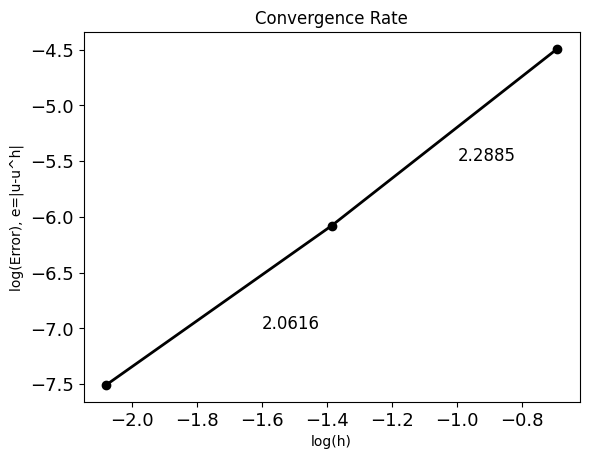

In [39]:
#numerical setting
L=1
dx=L*np.array([1/2,1/4,1/8])

#gauss intergration for local matrix
gaussPoint_x,gaussWeight_x=GaussQuad(10,-1,1)
gaussPoint_y=gaussPoint_x
gaussWeight_y=gaussWeight_x

idx_case=0 #index for each case
errorCase_u=np.zeros((len(dx),2))
errorCase_du=np.zeros((len(dx),2))

for dh in range(len(dx)):
    #define error
    error_u=0
    error_du=0

    #calculate Appx Solution
    dI=Main(dx[dh])

    constant,Parameter,nodalPosition,EFT=Get_Input(dx[dh])
    number_Element=Parameter[6] # if h=1/2 number_element=4

    # define N and B matrix
    N_matrix = lambda xi, eta: np.array([
        [(1/4) * (1-xi) * (1-eta), (1/4) * (xi+1) * (1-eta), (1/4) * (1+xi) * (1+eta), (1/4) * (1-xi) * (1+eta)]
    ])
    B_matrix = lambda xi, eta: np.array([
        [(1/4) * (eta-1), (1/4) * (1-eta), (1/4) * (eta+1), (1/4) * (-1-eta)],
        [(1/4) * (xi-1), (1/4) * (-1-xi), (1/4) * (xi+1), (1/4) * (1-xi)]
    ])

    for idxEle in range(number_Element):
        x1, y1 = nodalPosition[EFT[idxEle, 0] - 1]
        x2, y2 = nodalPosition[EFT[idxEle, 1] - 1]
        x3, y3 = nodalPosition[EFT[idxEle, 3] - 1]
        x4, y4 = nodalPosition[EFT[idxEle, 2] - 1]
        xI_Local = np.array([x1, x2, x3, x4])
        yI_Local = np.array([y1, y2, y3, y4])

        if x1 == 0.5 and y1 == 0.5: #中間點
            for idx_xGauss in range(len(gaussPoint_x)):
                for idx_yGauss in range(len(gaussPoint_y)):
                    # xi, eta = gaussPoint_x[idx_xGauss], gaussPoint_y[idx_yGauss]
                    xi=-1
                    eta=-1
                    N = N_matrix(xi, eta)
                    X = np.dot(xI_Local, N.T) #1*4@4*1 = 1
                    Y = np.dot(yI_Local, N.T)

                    B_xi = B_matrix(xi, eta)
                    A11 = np.dot(xI_Local, B_xi[0, :])
                    A12 = np.dot(yI_Local, B_xi[0, :])
                    A21 = np.dot(xI_Local, B_xi[1, :])
                    A22 = np.dot(yI_Local, B_xi[1, :])
                    A = np.array([[A11, A12], [A21, A22]])
                    B = np.linalg.solve(A, B_xi)

                    u1 = dI[EFT[idxEle, 0] - 1]
                    u2 = dI[EFT[idxEle, 1] - 1]
                    u3 = dI[EFT[idxEle, 3] - 1]
                    u4 = dI[EFT[idxEle, 2] - 1]
                    uh = u1 * N[0,0] + u2 * N[0,1] + u3 * N[0,2] + u4 * N[0,3]

                    uGradient = np.dot(B, np.array([u1, u2, u3, u4]))
                    uExact = np.exp(X) * np.exp(Y)

                    error_u += ((uExact - uh)**2) * np.linalg.det(A.T) * gaussWeight_x[idx_xGauss] * gaussWeight_y[idx_yGauss]

    X=0.5
    Y=0.5
    u_Exact=np.exp(X)*np.exp(Y)
    numNode=Parameter[7]
    error_u+=np.abs(u_Exact-dI[((numNode-1)//2)])
    # print(error_u)

    errorCase_u[idx_case,:]=[dx[dh],error_u[0]]
    errorCase_du[idx_case,:]=[dx[dh],error_du]
    idx_case+=1

idx_case-=1
# print(idx_case)

#Plot error
x=errorCase_u[:,0]
y=errorCase_u[:,1]
# print(errorCase_u)
# print(y)
# dx=errorCase_du[:,0]
# dy=errorCase_du[:,1:]

xx=np.log(x)
yy=np.log(y)
plt.plot(xx,yy,'ko-',lw=2)
plt.title('Convergence Rate')
plt.xlabel('log(h)')
plt.ylabel('log(Error), e=|u-u^h|')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# print(xx)
# print(yy)
#plot triangle
xd=x
yd=y
Slope=np.diff(yy,axis=0)/np.diff(xx,axis=0)
print(Slope)
plt.text(-1.6,-7.0,str(round(Slope[1],4)),fontsize=12)
plt.text(-1.0,-5.5, str(round(Slope[0],4)),fontsize=12)

plt.show()